<a href="https://colab.research.google.com/github/Nishant-Ramakuru/Inference-based-GNNS/blob/main/JAX_GNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install jraph
! pip install git+https://github.com/deepmind/dm-haiku

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 90 kB 4.0 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/deepmind/dm-haiku to /tmp/pip-req-build-fu64hlb0
  Running command git clone -q https://github.com/deepmind/dm-haiku /tmp/pip-req-build-fu64hlb0
  Created wheel for dm-haiku: filename=dm_haiku-0.0.8.dev0-py3-none-any.whl size=605363 sha256=73e1401a09d9f922f7b4d6183a880b9b750747bd4da1972e76afbc9f585a15fa
  Stored in directory: /tmp/pip-ephem-wheel-cache-k46mckh6/wheels/06/28/69/ebaac5b2435641427299f29d88d005fb4e2627f4a108f0bdbc
Successfully built dm-haiku


In [2]:
!pip install optax

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 145 kB 5.0 MB/s 
     |████████████████████████████████| 72 kB 584 kB/s 


In [3]:
import jax
import jax.numpy as jnp
import jraph
import networkx as nx
import numpy as onp
import haiku as hk
import pickle

import optax
from sklearn.metrics import roc_auc_score
#from absl import app, params, logging

import functools
from typing import List, Dict, Any, Tuple


Data

In [4]:
def load_dataset(path_to_dataset: str) -> jraph.GraphsTuple:
  with open(path_to_dataset, 'rb') as f:
      cora_ds = pickle.load(f)
  return cora_ds

def train_val_test_split_edges(graph: jraph.GraphsTuple,
                               val_perc: float = 0.05,
                               test_perc: float = 0.1):
  """Split edges in input graph into train, val and test splits.

  For val and test sets, also include negative edges.
  Based on torch_geometric.utils.train_test_split_edges.

  JAX implementation based fully on:
  https://github.com/deepmind/educational/blob/master/colabs/summer_schools/intro_to_graph_nets_tutorial_with_jraph.ipynb
  """
  mask = graph.senders < graph.receivers
  senders = graph.senders[mask]
  receivers = graph.receivers[mask]
  num_val = int(val_perc * senders.shape[0])
  num_test = int(test_perc * senders.shape[0])
  permuted_indices = onp.random.permutation(range(senders.shape[0]))
  senders = senders[permuted_indices]
  receivers = receivers[permuted_indices]
  if graph.edges is not None:
    edges = graph.edges[permuted_indices]

  val_senders = senders[:num_val]
  val_receivers = receivers[:num_val]
  if graph.edges is not None:
    val_edges = edges[:num_val]

  test_senders = senders[num_val:num_val + num_test]
  test_receivers = receivers[num_val:num_val + num_test]
  if graph.edges is not None:
    test_edges = edges[num_val:num_val + num_test]

  train_senders = senders[num_val + num_test:]
  train_receivers = receivers[num_val + num_test:]
  train_edges = None
  if graph.edges is not None:
    train_edges = edges[num_val + num_test:]

  # make training edges undirected by adding reverse edges back in
  train_senders_undir = jnp.concatenate((train_senders, train_receivers))
  train_receivers_undir = jnp.concatenate((train_receivers, train_senders))
  train_senders = train_senders_undir
  train_receivers = train_receivers_undir

  # Negative edges.
  num_nodes = graph.n_node[0]
  # Create a negative adjacency mask, s.t. mask[i, j] = True iff edge i->j does
  # not exist in the original graph.
  neg_adj_mask = onp.ones((num_nodes, num_nodes), dtype=onp.uint8)
  # upper triangular part
  neg_adj_mask = onp.triu(neg_adj_mask, k=1)
  neg_adj_mask[graph.senders, graph.receivers] = 0
  neg_adj_mask = neg_adj_mask.astype(onp.bool)
  neg_senders, neg_receivers = neg_adj_mask.nonzero()

  perm = onp.random.permutation(range(len(neg_senders)))
  neg_senders = neg_senders[perm]
  neg_receivers = neg_receivers[perm]

  val_neg_senders = neg_senders[:num_val]
  val_neg_receivers = neg_receivers[:num_val]
  test_neg_senders = neg_senders[num_val:num_val + num_test]
  test_neg_receivers = neg_receivers[num_val:num_val + num_test]

  train_graph = jraph.GraphsTuple(
      nodes=graph.nodes,
      edges=train_edges,
      senders=train_senders,
      receivers=train_receivers,
      n_node=graph.n_node,
      n_edge=jnp.array([len(train_senders)]),
      globals=graph.globals)

  return (
    train_graph, neg_adj_mask, 
    val_senders, val_receivers, val_neg_senders, val_neg_receivers, 
    test_senders, test_receivers, test_neg_senders, test_neg_receivers)

def negative_sampling(
    graph: jraph.GraphsTuple, num_neg_samples: int,
    key: jnp.DeviceArray) -> Tuple[jnp.DeviceArray, jnp.DeviceArray]:
  """Samples negative edges, i.e. edges that don't exist in the input graph.
  
  Based fully on:
  https://github.com/deepmind/educational/blob/master/colabs/summer_schools/intro_to_graph_nets_tutorial_with_jraph.ipynb
  """
  num_nodes = graph.n_node[0]
  total_possible_edges = num_nodes**2
  # convert 2D edge indices to 1D representation.
  pos_idx = graph.senders * num_nodes + graph.receivers

  # Percentage to oversample edges, so most likely will sample enough neg edges.
  alpha = jnp.abs(1 / (1 - 1.1 *
                       (graph.senders.shape[0] / total_possible_edges)))

  perm = jax.random.randint(
      key,
      shape=(int(alpha * num_neg_samples),),
      minval=0,
      maxval=total_possible_edges,
      dtype=jnp.uint32)

  # mask where sampled edges are positive edges.
  mask = jnp.isin(perm, pos_idx)
  # remove positive edges.
  perm = perm[~mask][:num_neg_samples]

  # convert 1d back to 2d edge indices.
  neg_senders = perm // num_nodes
  neg_receivers = perm % num_nodes

  return neg_senders, neg_receivers

def convert_jraph_to_networkx_graph(jraph_graph: jraph.GraphsTuple) -> nx.Graph:
  """Converts a JAX GraphsTuple to a NetworkX graph.
  
  Based fully on: 
  https://github.com/deepmind/educational/blob/master/colabs/summer_schools/intro_to_graph_nets_tutorial_with_jraph.ipynb
  """
  nodes, edges, receivers, senders, _, _, _ = jraph_graph
  nx_graph = nx.DiGraph()
  if nodes is None:
    for n in range(jraph_graph.n_node[0]):
      nx_graph.add_node(n)
  else:
    for n in range(jraph_graph.n_node[0]):
      nx_graph.add_node(n, node_feature=nodes[n])
  if edges is None:
    for e in range(jraph_graph.n_edge[0]):
      nx_graph.add_edge(int(senders[e]), int(receivers[e]))
  else:
    for e in range(jraph_graph.n_edge[0]):
      nx_graph.add_edge(
          int(senders[e]), int(receivers[e]), edge_feature=edges[e])
  return nx_graph

def compute_norm_and_weights(graph: jraph.GraphsTuple) -> Tuple[float, float]:
  graph_n_node = graph.n_node.item()
  graph_adj = nx.to_numpy_matrix(convert_jraph_to_networkx_graph(graph))
  adj_sum = onp.sum(graph_adj)
  pos_weight = float(graph_n_node**2 - adj_sum) / adj_sum
  norm_adj = graph_n_node**2 / 2.0*(graph_n_node**2 - adj_sum)
  return pos_weight, norm_adj

Model

In [5]:
def vgae_encoder(graph: jraph.GraphsTuple,
                 hidden_dim: int,
                 latent_dim: int) -> Tuple[jraph.GraphsTuple, jraph.GraphsTuple]:
  """VGAE network definition."""
  graph = graph._replace(globals=jnp.zeros([graph.n_node.shape[0], 1]))
  
  @jraph.concatenated_args
  def hidden_node_update_fn(feats: jnp.ndarray) -> jnp.ndarray:
    """Node update function for hidden layer."""
    net = hk.Sequential([hk.Linear(hidden_dim), jax.nn.relu])
    return net(feats)

  @jraph.concatenated_args
  def latent_node_update_fn(feats: jnp.ndarray) -> jnp.ndarray:
    """Node update function for latent layer."""
    return hk.Linear(latent_dim)(feats)

  net_hidden = jraph.GraphConvolution(
    update_node_fn=hidden_node_update_fn,
    add_self_edges=True
  )
  h = net_hidden(graph)
  
  net_mean = jraph.GraphConvolution(
    update_node_fn=latent_node_update_fn,
    add_self_edges=True
  )
  net_log_std = jraph.GraphConvolution(
    update_node_fn=latent_node_update_fn,
    add_self_edges=True
  )
  mean, log_std = net_mean(h), net_log_std(h)
  return mean, log_std
  

def gae_encoder(graph: jraph.GraphsTuple,
                hidden_dim: int,
                latent_dim: int) -> jraph.GraphsTuple:
  """GAE network definition."""
  graph = graph._replace(globals=jnp.zeros([graph.n_node.shape[0], 1]))
  
  @jraph.concatenated_args
  def node_update_fn(feats: jnp.ndarray) -> jnp.ndarray:
    net = hk.Sequential([hk.Linear(hidden_dim), jax.nn.relu, hk.Linear(latent_dim)])
    return net(feats)
  
  net = jraph.GraphConvolution(
    update_node_fn=node_update_fn, 
    add_self_edges=True)
  return net(graph)


def inner_product_decode(pred_graph_nodes: jnp.ndarray, senders: jnp.ndarray,
           receivers: jnp.ndarray) -> jnp.ndarray:
  """Given a set of candidate edges, take dot product of respective nodes.

  Args:
    pred_graph_nodes: input graph nodes Z.
    senders: Senders of candidate edges.
    receivers: Receivers of candidate edges.

  Returns:
    For each edge, computes dot product of the features of the two nodes.

  """
  return jnp.squeeze(
      jnp.sum(pred_graph_nodes[senders] * pred_graph_nodes[receivers], axis=1))

Loss

In [6]:
def compute_vgae_loss(params: hk.Params, graph: jraph.GraphsTuple,
                 senders: jnp.ndarray, receivers: jnp.ndarray,
                 labels: jnp.ndarray,
                 net: hk.Transformed, 
                 rng_key: jnp.ndarray) -> Tuple[jnp.ndarray, jnp.ndarray]:
  """Computes VGAE loss."""
  mean_graph, log_std_graph = net.apply(params, graph)
  
  mean, log_std = mean_graph.nodes, log_std_graph.nodes
  eps = jax.random.normal(rng_key, mean.shape)
  z = mean + eps * jnp.exp(log_std)
  logits = inner_product_decode(z, senders, receivers)
  
  n_node = z.shape[0]
  kld = 1.0/n_node * jnp.mean(compute_kl_gaussian(mean, log_std), axis=-1)
  log_likelihood = compute_bce_with_logits_loss(logits, labels)
  
  loss = log_likelihood + kld  # want to maximize this quantity.
  return loss, logits


def compute_gae_loss(params: hk.Params, graph: jraph.GraphsTuple,
                 senders: jnp.ndarray, receivers: jnp.ndarray,
                 labels: jnp.ndarray,
                 net: hk.Transformed) -> Tuple[jnp.ndarray, jnp.ndarray]:
  """Computes GAE loss."""
  pred_graph = net.apply(params, graph)
  logits = inner_product_decode(pred_graph.nodes, senders, receivers)
  loss = compute_bce_with_logits_loss(logits, labels)
  return loss, logits


def compute_bce_with_logits_loss(x: jnp.ndarray, y: jnp.ndarray) -> jnp.ndarray:
  """Computes binary cross-entropy with logits loss.

  Combines sigmoid and BCE, and uses log-sum-exp trick for numerical stability.
  See https://stackoverflow.com/a/66909858 if you want to learn more.

  Args:
    x: Predictions (logits).
    y: Labels.

  Returns:
    Binary cross-entropy loss with mean aggregation.

  """
  max_val = jnp.clip(-x, 0, None)
  loss = x - x*y + max_val + jnp.log(jnp.exp(-max_val) + jnp.exp((-x-max_val)))
  return jnp.mean(loss, axis=-1)


def compute_weighted_bce_with_logits_loss(
  x: jnp.ndarray, y: jnp.ndarray, weight: jnp.ndarray) -> jnp.ndarray:
  """Computes weighted binary cross-entropy with logits loss.

  Combines sigmoid and BCE, and uses log-sum-exp trick for numerical stability.
  See https://stackoverflow.com/a/66909858 if you want to learn more.

  Args:
    x: Predictions (logits).
    y: Labels.

  Returns:
    Binary cross-entropy loss.

  """
  max_val = jnp.clip(-x, 0, None)
  loss = x - x*y + max_val + jnp.log(jnp.exp(-max_val) + jnp.exp((-x-max_val)))
  loss = weight * loss
  return jnp.mean(loss, axis=-1)


def compute_kl_gaussian(mean: jnp.ndarray, log_std: jnp.ndarray) -> jnp.ndarray:
    r"""Calculate KL divergence between given and standard gaussian distributions.

    Args:
        mean: feature matrix of the mean.
        log_std: feature matrix of the log-covariance.

    Returns:
        A vector representing KL divergence of the two Gaussian distributions
        of length |V| where V is the nodes in the graph.
    """
    var = jnp.exp(log_std)
    return 0.5 * jnp.sum(
      -2*log_std - 1.0 + jnp.square(var) + jnp.square(mean), axis=-1)
  
  

Train

In [7]:
parameters = {}
parameters['learning_rate'] = 1e-2 # 'Learning rate for the optimizer.')
parameters['epochs'] =200 #, 'Number of training epochs.')
parameters['hidden_dim'] =32 #, 'Hidden dimension in the AE.')
parameters['latent_dim']= 16 #, 'Latent dimension in the AE.')
parameters['random_seed'] =42 #, 'Random seed.')
parameters['eval_frequency'] = 10 #, 'How often to evaluate the model.')
parameters['is_vgae']= True #, 'Using Variational GAE vs vanilla GAE.')

In [8]:
def compute_roc_auc_score(preds: jnp.ndarray,
                          labels: jnp.ndarray) -> jnp.ndarray:
  """Computes roc auc (area under the curve) score for classification."""
  s = jax.nn.sigmoid(preds)
  roc_auc = roc_auc_score(labels, s)
  return roc_auc


def train(dataset: List[Dict[str, Any]]) -> hk.Params:
  """Training loop."""
  key = jax.random.PRNGKey(parameters['random_seed'])
  # Transform impure network to pure functions with hk.transform.
  net_fn = vgae_encoder if parameters['is_vgae'] else gae_encoder
  net_fn = functools.partial(
    net_fn, hidden_dim=parameters['hidden_dim'], latent_dim=parameters['latent_dim'])
  net = hk.without_apply_rng(hk.transform(net_fn))
  
  # Get a candidate graph and label to initialize the network.
  graph = dataset[0]['input_graph']
  train_graph, _, val_pos_s, val_pos_r, val_neg_s, val_neg_r, test_pos_s, \
      test_pos_r, test_neg_s, test_neg_r = train_val_test_split_edges(
      graph)

  # Prepare the validation and test data.
  val_senders = jnp.concatenate((val_pos_s, val_neg_s))
  val_receivers = jnp.concatenate((val_pos_r, val_neg_r))
  val_labels = jnp.concatenate(
      (jnp.ones(len(val_pos_s)), jnp.zeros(len(val_neg_s))))
  test_senders = jnp.concatenate((test_pos_s, test_neg_s))
  test_receivers = jnp.concatenate((test_pos_r, test_neg_r))
  test_labels = jnp.concatenate(
      (jnp.ones(len(test_pos_s)), jnp.zeros(len(test_neg_s))))
  # Initialize the network.
  key, param_key = jax.random.split(key)
  params = net.init(param_key, train_graph)
  # Initialize the optimizer.
  opt_init, opt_update = optax.adam(parameters['learning_rate'])
  opt_state = opt_init(params)
  
  if parameters['is_vgae']:
    key, loss_key = jax.random.split(key)
    loss_fn = functools.partial(compute_vgae_loss, rng_key=loss_key)
  else:
    loss_fn = compute_gae_loss
  compute_loss_fn = functools.partial(loss_fn, net=net)
  # We jit the computation of our loss, since this is the main computation.
  compute_loss_fn = jax.jit(jax.value_and_grad(compute_loss_fn, has_aux=True))

  key, *neg_sampling_keys = jax.random.split(key, parameters['epochs']+1)
  for epoch in range(parameters['epochs']):
    num_neg_samples = train_graph.senders.shape[0]
    train_neg_senders, train_neg_receivers = negative_sampling(
        train_graph, num_neg_samples=num_neg_samples, key=neg_sampling_keys[epoch])
    train_senders = jnp.concatenate((train_graph.senders, train_neg_senders))
    train_receivers = jnp.concatenate(
        (train_graph.receivers, train_neg_receivers))
    train_labels = jnp.concatenate(
        (jnp.ones(len(train_graph.senders)), jnp.zeros(len(train_neg_senders))))
  
    (train_loss,
     train_preds), grad = compute_loss_fn(params, train_graph, train_senders,
                                          train_receivers, train_labels)

    updates, opt_state = opt_update(grad, opt_state, params)
    params = optax.apply_updates(params, updates)
    if epoch % parameters['eval_frequency'] == 0 or epoch == (parameters['epochs'] - 1):
      train_roc_auc = compute_roc_auc_score(train_preds, train_labels)
      val_loss, val_preds = loss_fn(params, train_graph, val_senders,
                                         val_receivers, val_labels, net)
      val_roc_auc = compute_roc_auc_score(val_preds, val_labels)

      print('epoch:' ,{epoch}, 'train_loss:', train_loss,
            'train_roc_auc:', train_roc_auc, 'val_loss:', val_loss, 
            'val_roc_auc:', val_roc_auc)

  test_loss, test_preds = loss_fn(params, train_graph, test_senders,
                                       test_receivers, test_labels, net)
  test_roc_auc = compute_roc_auc_score(test_preds, test_labels)
  print('Training finished')
  print('epoch:', epoch, 'test_loss:', test_loss, 'test_roc_auc:', test_roc_auc)
  return params


def main():
    cora_ds = load_dataset('/content/drive/MyDrive/GNNs/cora.pickle')
    result = train(cora_ds)
    return result

In [10]:
r = main()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


epoch: {0} train_loss: 1.6926074 train_roc_auc: 0.5023390136621008 val_loss: 1.333391 val_roc_auc: 0.5310326880538969
epoch: {10} train_loss: 0.6425334 train_roc_auc: 0.832690911652702 val_loss: 0.64776397 val_roc_auc: 0.7875927077158844


KeyboardInterrupt: ignored

In [11]:
cora_ds = load_dataset('/content/drive/MyDrive/GNNs/cora.pickle')

In [12]:
type(cora_ds)

list

In [13]:
adjacency_matrix = cora_ds[0]['input_graph'][0]

In [14]:
adjacency_matrix.shape

(2708, 1433)

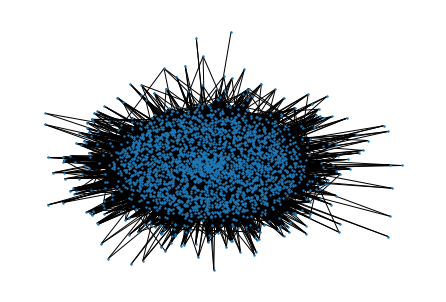

In [15]:
import numpy as np
import matplotlib.pyplot as plt
def show_graph_with_labels(adjacency_matrix):
    rows, cols = np.where(adjacency_matrix == 1)
    edges = zip(rows.tolist(), cols.tolist())
    gr = nx.Graph()
    gr.add_edges_from(edges)
    nx.draw(gr, node_size=2, with_labels=False)
    plt.show()

#x = [str(i) for i in range(0,50)]
show_graph_with_labels(adjacency_matrix)

In [ ]:
2708*1433

In [20]:
cora_ds[0]

{'input_graph': GraphsTuple(nodes=array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32), edges=None, receivers=array([ 633, 1862, 2582, ...,  598, 1473, 2706], dtype=int32), senders=array([   0,    0,    0, ..., 2707, 2707, 2707], dtype=int32), globals=None, n_node=array([2708], dtype=int32), n_edge=array([10556], dtype=int32)),
 'target': array([3, 4, 4, ..., 3, 3, 3], dtype=int32)}

In [ ]:
boids=[]

boid_dict = {'input_graph':
  
}

In [16]:
edges = np.ones(50) - np.eye(50)
send_edges = np.where(edges)[0]
recv_edges = np.where(edges)[1]

In [17]:
send_edges.shape

(2450,)

In [ ]:
receivers = hidden[:, self.recv_edges, :]
senders = hidden[:, self.send_edges, :]